# **0. 참고자료**
## **0-1. 도서**   

## **0-2. 논문, 학술지**

## **0-3. 웹 사이트**

## **0-4. 데이터셋 출처**
- Kaggle - BIRDS 400 - SPECIES IMAGE CLASSIFICATION | [[데이터 셋 링크]](https://www.kaggle.com/datasets/gpiosenka/100-bird-species)


In [1]:
## json 파일 업로드 확인
!ls -1ha ~/dove/TIL/api/kaggle.json

## 캐글 숨김 폴더 생성
!mkdir -p ~/.kaggle

## 토큰 파일 옮기고, 권한 부여
!cp  ~/dove/TIL/api/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

## 데이터 셋 다운로드
!kaggle datasets download -d gpiosenka/100-bird-species

## 파일 옮기기
!mkdir -p ~/dove/TIL/AI_study/datasets/zip
!mv 100-bird-species.zip ~/dove/TIL/AI_study/datasets/zip/birds.zip

/home/jovyan/dove/TIL/api/kaggle.json
100%|█████████████████████████████████████▉| 1.49G/1.49G [02:28<00:00, 11.7MB/s]
100%|██████████████████████████████████████| 1.49G/1.49G [02:28<00:00, 10.8MB/s]


In [ ]:
!unzip ~/dove/TIL/AI_study/datasets/zip/birds.zip -d ~/dove/TIL/AI_study/datasets/birds

In [25]:
## 미리 만들어둔 데이터 모듈 이용
from utils import dataset_util
import random

In [2]:
(train_img, train_lb), (lb2idx, idx2lb) = dataset_util.build_dataset('/home/jovyan/dove/TIL/AI_study/datasets/birds/train')

In [3]:
(test_img, test_lb), _ = dataset_util.build_dataset('/home/jovyan/dove/TIL/AI_study/datasets/birds/test')
(valid_img, valid_lb), _ = dataset_util.build_dataset('/home/jovyan/dove/TIL/AI_study/datasets/birds/valid')

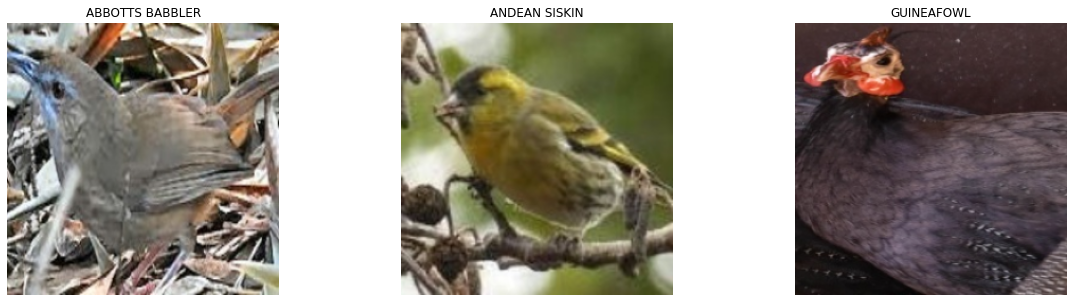

In [42]:
train_sample_idx = random.sample(range(len(train_img)), 3) 

f, axes = plt.subplots(1, 3)
f.set_size_inches((20, 5))

for idx, sample_idx in enumerate(train_sample_idx):
    axes[idx].imshow(train_img[sample_idx])
    axes[idx].axis(False)
    axes[idx].set_title(idx2lb[train_lb[sample_idx]])

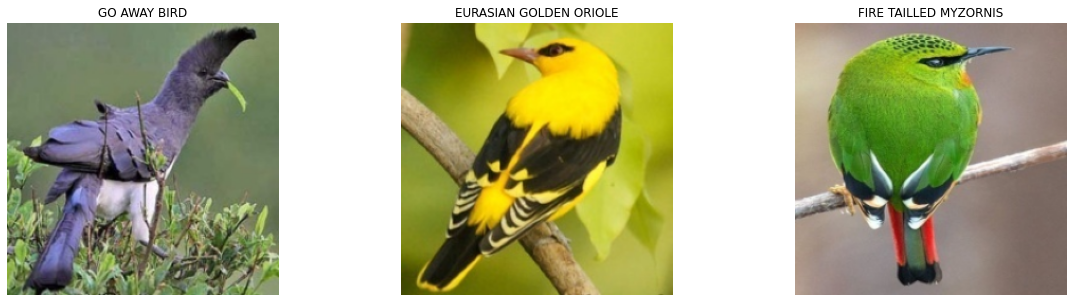

In [44]:
test_sample_idx = random.sample(range(len(test_img)), 3) 

f, axes = plt.subplots(1, 3)
f.set_size_inches((20, 5))

for idx, sample_idx in enumerate(test_sample_idx):
    axes[idx].imshow(test_img[sample_idx])
    axes[idx].axis(False)
    axes[idx].set_title(idx2lb[test_lb[sample_idx]])

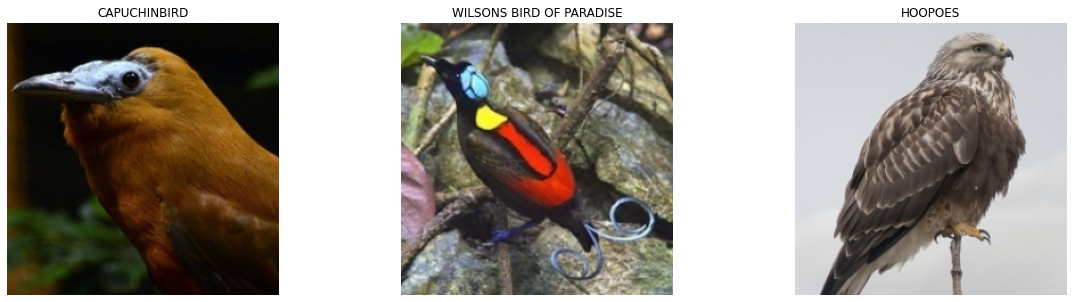

In [45]:
valid_sample_idx = random.sample(range(len(valid_img)), 3) 

f, axes = plt.subplots(1, 3)
f.set_size_inches((20, 5))

for idx, sample_idx in enumerate(valid_sample_idx):
    axes[idx].imshow(valid_img[sample_idx])
    axes[idx].axis(False)
    axes[idx].set_title(idx2lb[valid_lb[sample_idx]])

In [7]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import numpy as np
import torch

In [8]:
USE_CUDA = torch.cuda.is_available()
DEVICE   = torch.device('cuda' if USE_CUDA else 'cpu')

BATCH_SIZE = 32 
MOMENTUM   = 0.9
EPOCHS     = 100
STEP       = 30
LR         = 1e-2

In [9]:
class BirdsDataset(Dataset):
    
    def __init__(self, images, labels, dtype = 'train'):
        
        self.images = images
        self.labels = labels
        self.dtype  = dtype
        
        self.transforms          = {}
        self.transforms['train'] = transforms.Compose([
                                                transforms.ToPILImage(),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.RandomCrop(224),
                                                transforms.ToTensor()
                                            ])
        self.transforms['valid'] = transforms.Compose([
                                                transforms.ToPILImage(),
                                                transforms.Resize(224),
                                                transforms.ToTensor()
                                            ])
        
        self.transforms['test'] = transforms.Compose([
                                                transforms.ToPILImage(),
                                                transforms.Resize(224),
                                                transforms.ToTensor()
                                            ])
        
        self.num_datas = self.labels.shape[0]
        
    
    def __getitem__(self, index):
        
        image = self.images[index]
        image = self.transforms[self.dtype](image)
        
        return image, self.labels[index]
    
    def __len__(self):
        return self.num_datas

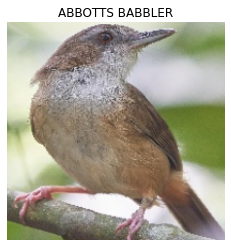

In [24]:
train_dataset  = BirdsDataset(train_img, train_lb)
train_loader   = DataLoader(train_dataset, batch_size = BATCH_SIZE)

train_iter     = iter(train_loader)
images, labels = next(train_iter)
image, lb      = images[3], labels[3]

dataset_util.display_image((image, lb.item()), idx2lb)

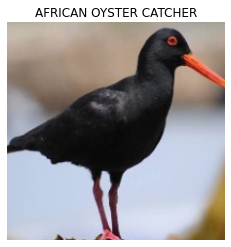

In [11]:
valid_dataset  = BirdsDataset(valid_img, valid_lb)
valid_loader   = DataLoader(valid_dataset, batch_size = BATCH_SIZE)

valid_iter     = iter(valid_loader)
images, labels = next(valid_iter)
image, lb      = images[31], labels[31]

dataset_util.display_image((image, lb.item()), idx2lb)

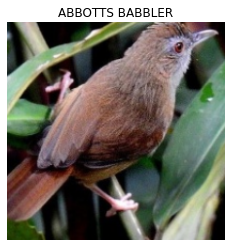

In [12]:
test_dataset   = BirdsDataset(test_img, test_lb)
test_loader    = DataLoader(test_dataset, batch_size = 1)

test_iter     = iter(test_loader)
images, labels = next(test_iter)
image, lb      = images[0], labels[0]

dataset_util.display_image((image, lb.item()), idx2lb)

In [13]:
## 저번 꽤나 괜찮은 성능을 보여줬던 모델 구성을 그대로 사용해보자
class BirdsNet(nn.Module):
    
    def __init__(self):
        super(BirdsNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size = 3, stride = 1)
        self.bn1   = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 32, kernel_size = 3, stride = 1)
        self.bn2   = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 16, kernel_size = 3, stride = 1)
        self.bn3   = nn.BatchNorm2d(16)
        
        self.conv4 = nn.Conv2d(16, 8, kernel_size = 3, stride = 1)
        self.bn4   = nn.BatchNorm2d(8)
        
        self.drop  = nn.Dropout2d()
        self.fc1   = nn.Linear(72, 64)
        self.fc2   = nn.Linear(64, 32)
        self.fc3   = nn.Linear(32, 16)        
        self.fc4   = nn.Linear(16, 400)
        
    def forward(self, x):

        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.bn1(x)
        
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = self.bn2(x)
            
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = self.bn3(x)

        x = self.bn4(self.conv4(x))
        x = F.avg_pool2d(x, 8)

        x = x.view(-1, 72)
        
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        
        x = F.relu(self.fc2(x))
        x = self.drop(x)

        x = F.relu(self.fc3(x))
        x = self.drop(x)

        x = self.fc4(x)
        return F.log_softmax(x, dim = 1)

In [14]:
def train(model, train_loader, optimizer):
    model.train()
    train_loss, correct = 0, 0
    
    for image, lb in train_loader:
        image, lb   = image.to(DEVICE), lb.to(DEVICE)
        optimizer.zero_grad()
        
        output = model(image)
        loss   = F.cross_entropy(output, lb)
        
        loss.backward()
        optimizer.step()
        
        pred = output.max(1, keepdim = True)[1]
        correct += pred.eq(lb.view_as(pred)).sum().item()
        train_loss += loss
        
    train_loss /= len(train_loader.dataset)
    train_acc   = 100 * correct / len(train_loader.dataset)
    
    return train_loss, train_acc


def evaluate(model, test_loader):
    model.eval()
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for img, lb in test_loader:
            img, lb   = img.to(DEVICE), lb.to(DEVICE)
            output = model(img)
            
            loss   = F.cross_entropy(output, lb)
            pred = output.max(1, keepdim = True)[1]
            
            correct += pred.eq(lb.view_as(pred)).sum().item()
            test_loss += loss
        
    test_loss /= len(test_loader.dataset)
    test_acc   = 100 * correct / len(test_loader.dataset)
    
    return test_loss, test_acc   

In [ ]:
model = BirdsNet().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr = LR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = STEP, gamma = 0.1)

## 기존 학습 과정과는 다르게 로그 그래프도 그려보기 위해 리스트를 생성함.
history = {
                'train_loss' : [],
                'train_acc'  : [],
                'valid_loss' : [],
                'valid_acc'  : []
            }

## 학습을 돌려보자
for epoch in range(1, EPOCHS + 1):
  scheduler.step()

  train_loss, train_acc = train(model, train_loader, optimizer)
  history['train_loss'].append(train_loss.item())
  history['train_acc'].append(train_acc)

  valid_loss, valid_acc = evaluate(model, valid_loader)
  history['valid_loss'].append(valid_loss.item())
  history['valid_acc'].append(valid_acc)
    
  print(f'[{epoch} / {EPOCHS}] \nTrain Loss : {train_loss:.3f} | Train Acc : {train_acc:.3f} \nValid Loss : {valid_loss:.3f} | Valid Acc : {valid_acc:.3f} \n')

- 기존에 만들어 두었던 모델은 성능이 제대로 나오지 않는것으로 보였다.

[1 / 100]  
Train Loss : 0.241 | Train Acc : 0.005  
Valid Loss : 0.203 | Valid Acc : 0.250  

[2 / 100]  
Train Loss : 0.201 | Train Acc : 0.175  
Valid Loss : 0.191 | Valid Acc : 0.250  

[3 / 100]  
Train Loss : 0.196 | Train Acc : 0.000  
Valid Loss : 0.189 | Valid Acc : 0.250  

[4 / 100]  
Train Loss : 0.196 | Train Acc : 0.000  
Valid Loss : 0.189 | Valid Acc : 0.250  

[5 / 100]  
Train Loss : 0.196 | Train Acc : 0.000  
Valid Loss : 0.189 | Valid Acc : 0.250  

[6 / 100]  
Train Loss : 0.197 | Train Acc : 0.000  
Valid Loss : 0.190 | Valid Acc : 0.250  

[7 / 100]  
Train Loss : 0.197 | Train Acc : 0.000  
Valid Loss : 0.190 | Valid Acc : 0.250  

[8 / 100]  
Train Loss : 0.197 | Train Acc : 0.000  
Valid Loss : 0.190 | Valid Acc : 0.250  

- 사전학습 된 모델로 전이학습을 해보자  
- 우선 데이터 셋 압축파일에 있던 모델인 efficientnet B4로 학습시켜보자

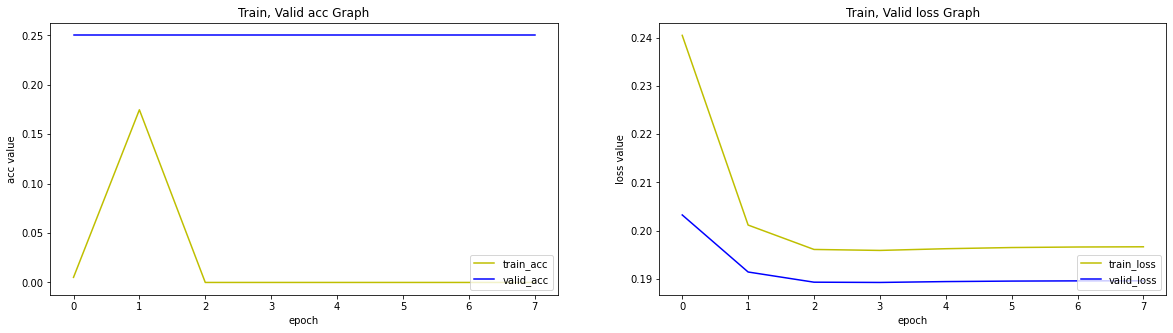

In [17]:
dataset_util.display_history(history, 8)